In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import glob

from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.models import resnet50, vgg16, vit_b_16
from torchvision.datasets.imagenet import ImageNet, parse_devkit_archive
from tqdm import tqdm
from PIL import Image

from infor_RISE_torch import *
from utils import *

In [2]:
# architecture = 'VGG'

# if architecture == 'VGG':
#     core = vgg16(weights = 'DEFAULT')
#     core.eval()
#     core = core.to(device)  
#     input_size = 224
#     transform = transforms.Compose([transforms.Resize((input_size,input_size)),
#                                 transforms.ToTensor()])
    
#     epochs = 10
#     n_masks = 20

# elif architecture == 'ResNET':
#     core = resnet50(weights = 'DEFAULT')
#     core.eval()
#     core = core.to(device)
#     input_size = 224
#     transform = transforms.Compose([transforms.Resize((input_size,input_size)),
#                                 transforms.ToTensor()])    
    
#     epochs = 10
#     n_masks = 20

# elif architecture == 'ViT':
#     core = vit_b_16(weights = 'DEFAULT')
#     core.eval()
#     core = core.to(device)
#     input_size = 224
#     transform = transforms.Compose([transforms.Resize((input_size,input_size)),
#                                 transforms.ToTensor()])    
    
#     epochs = 10
#     n_masks = 20

# k = 224*224*3

In [3]:
architectures = ['VGG', 'ViT']

saliencies = []
for architecture in architectures:

    if architecture == 'VGG':
        core = vgg16(weights = 'DEFAULT')
        core.eval()
        core = core.to(device)  
        input_size = 224
        transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor()])
        
        epochs = 10
        n_masks = 20

    elif architecture == 'ResNET':
        core = resnet50(weights = 'DEFAULT')
        core.eval()
        core = core.to(device)
        input_size = 224
        transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor()])    
        
        epochs = 10
        n_masks = 20

    elif architecture == 'ViT':
        core = vit_b_16(weights = 'DEFAULT')
        core.eval()
        core = core.to(device)
        input_size = 224
        transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor()])    
        
        epochs = 10
        n_masks = 20

    k = 224*224*3

    new_layer = InfoLayer(mask_range=3, mask_size=7, input_size=input_size)
    new_layer = new_layer.to(device=device)

    new_core = InfoModel(core=core, bottleneck=new_layer)
    new_core = new_core.to(device=device)

    P = list(new_core.parameters())

    files = glob.glob('./test_images/*')
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])  
    optimizer = torch.optim.Adam(P, lr=1)
    loss_ce = nn.CrossEntropyLoss()
    loss_inf = InfoLoss(beta=100/k, phi=100/k)


    pil_img = Image.open('./test_images/test_image2.JPEG').convert('RGB')

    img = transform(pil_img)
    x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    x = x[None,...].to(device)

    preds = core(x)
    # y = torch.argmax(preds, dim=1)
    # y = y.to(device)

    y = torch.tensor([23])

    saliency_list = []
    logit_list = []
    probs_list = []
    for _ in range(n_masks):
        new_core.reset_model()
        s,l,p = train_bottleneck(model=new_core, x=x, y=y, loss_ce=loss_ce, loss_inf=loss_inf, sigma=1, opt=optimizer, epochs=epochs)  
        saliency_list.append(s)
        logit_list.append(l)
        probs_list.append(p)

    final_saliency = torch.tensor([0])
    for i in range(len(saliency_list)):
        s = saliency_list[i][-1]
        final_saliency = final_saliency + s

    final_saliency = final_saliency.detach().cpu().numpy()
    saliencies.append(final_saliency)

/tmp/ipykernel_27299/1405362856.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  final_saliency = final_saliency + s


In [4]:

# pil_img = Image.open('./test_images/test_image2.JPEG').convert('RGB')

# img = transform(pil_img)
# x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
# x = x[None,...].to(device)

# preds = core(x)
# # y = torch.argmax(preds, dim=1)
# # y = y.to(device)

# y = torch.tensor([23])

# saliency_list = []
# logit_list = []
# probs_list = []
# for _ in range(n_masks):
#     new_core.reset_model()
#     s,l,p = train_bottleneck(model=new_core, x=x, y=y, loss_ce=loss_ce, loss_inf=loss_inf, sigma=1, opt=optimizer, epochs=epochs)  
#     saliency_list.append(s)
#     logit_list.append(l)
#     probs_list.append(p)

# final_saliency = torch.tensor([0])
# for i in range(len(saliency_list)):
#     s = saliency_list[i][-1]
#     final_saliency = final_saliency + s

# final_saliency_vgg = final_saliency.detach().cpu().numpy()


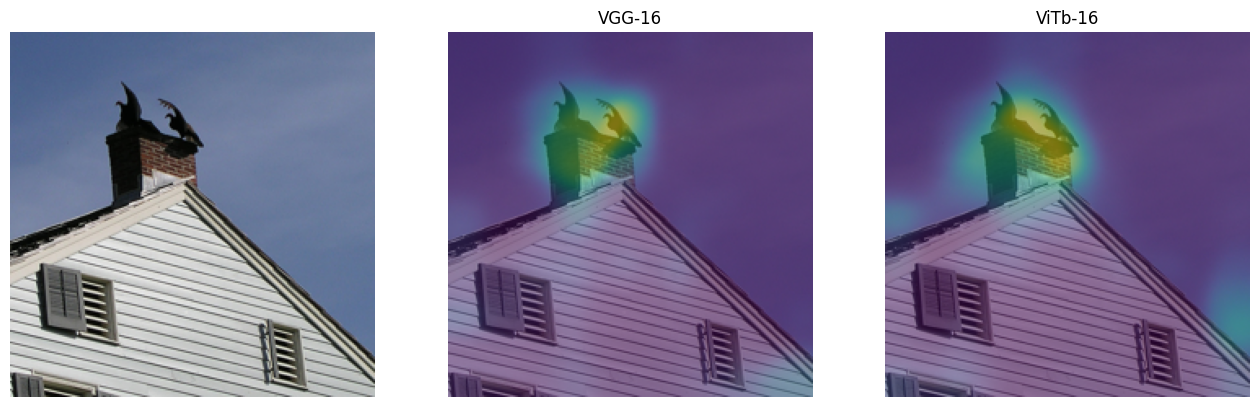

In [6]:
f, ax = plt.subplots(1,3, figsize=(16,20))
ax[0].imshow(pil_img.resize((224,224)))
ax[0].axis('off')

ax[1].imshow(pil_img.resize((224,224)))
ax[1].imshow(np.squeeze(saliencies[0]), cmap='viridis', alpha=0.5)
ax[1].title.set_text('VGG-16')
ax[1].axis('off')


ax[2].imshow(pil_img.resize((224,224)))
ax[2].imshow(np.squeeze(saliencies[1]), cmap='viridis', alpha=0.5)
ax[2].title.set_text('ViTb-16')
ax[2].axis('off')

plt.show()